#### Importing libraries

In [41]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimpy import skim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### Loading for loading the data from drive

In [105]:
housing = pd.read_csv('housing.csv')

In [106]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### basic exploration of the data

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


<AxesSubplot:>

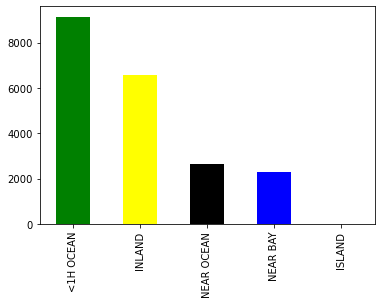

In [60]:
# categorical count of unique instance in the ocean_proximity attribute
print(housing['ocean_proximity'].value_counts())
housing['ocean_proximity'].value_counts().plot(kind='bar',color=['green','yellow','black','blue','red'])

In [61]:
# Summary statistics of each numerical attribute
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<AxesSubplot:>

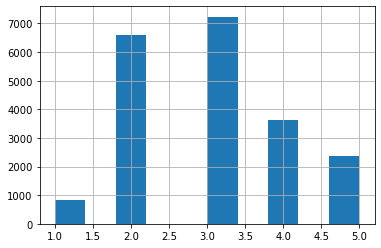

In [62]:
## Create an income category; this would help ensure proper representation of every income group in the test and train sets
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0,1.5,3.0,4.5,6.,np.inf],
                              labels=[1,2,3,4,5])
housing['income_cat'].hist()

#### Create train & test set

In [63]:
# using StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing['income_cat']):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

#### Comprehensive data exploration

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

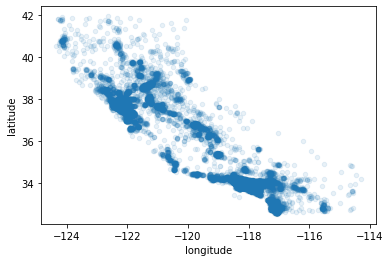

In [64]:
#Scatter plots for all districts. alpha is set to 0.1 to see high density areas
train.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

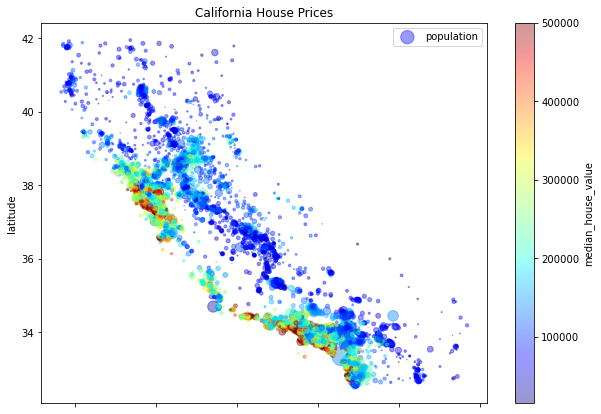

In [65]:
# Creating heat map showing median_house_value on the population density scatter plot
train.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=train['population']/100,label='population',figsize=(10,7),c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True)
plt.title('California House Prices')
plt.legend()

In [66]:
# Computing the correlation between the target value (median_house_value) and features
matrix = train.corr()
matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:>

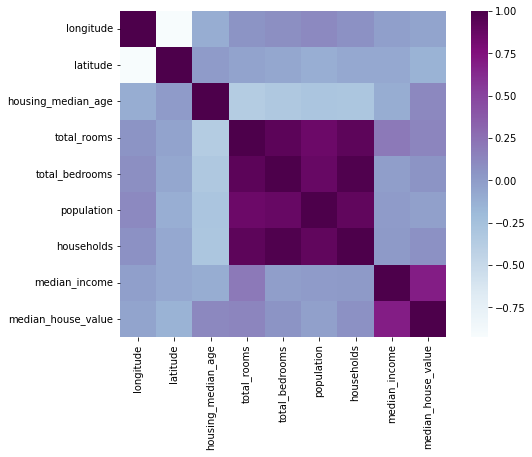

In [67]:
# correlation matrix
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,square=True,cmap="BuPu")

In [68]:
# Checking for skewness of the data for the numerical columns
train[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']].skew().sort_values(ascending=False)

population            4.741568
total_rooms           4.000836
total_bedrooms        3.269270
households            3.222081
median_income         1.653353
median_house_value    0.986813
latitude              0.461456
housing_median_age    0.059468
longitude            -0.293555
dtype: float64

In [71]:
train.shape

(16512, 11)

In [72]:
# Feature extraction; creating new variables
train['room_per_household'] = train['total_rooms']/train['households']
train['bedrooms_per_room'] = train['total_bedrooms']/train['total_rooms']
train['population_per_household'] = train['population']/train['households']

In [73]:
# Checking correlation again
corr_matrix2 = train.corr()
corr_matrix2['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
room_per_household          0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [74]:
train = train.drop(columns=['total_rooms','total_bedrooms','population_per_household','households'])

In [75]:
# Checking for skewness of the data for the numerical columns
train[['longitude', 'latitude', 'housing_median_age','population','median_income','median_house_value','room_per_household',
       'bedrooms_per_room']].skew().sort_values(ascending=False)

room_per_household    21.422538
population             4.741568
bedrooms_per_room      2.002516
median_income          1.653353
median_house_value     0.986813
latitude               0.461456
housing_median_age     0.059468
longitude             -0.293555
dtype: float64

In [78]:
train['longitude'] = train['longitude'] + 126

In [79]:
lists = ['longitude', 'latitude', 'housing_median_age','population','median_income','room_per_household','bedrooms_per_room']

In [ ]:
#### Reducing skewness in the data

In [80]:
for col in lists:
    train[col] = np.log(train[col])

In [ ]:
#### Handling skewness in the data

In [90]:
train = train.drop('income_cat',axis=1)

### Data cleaning, preprocessing and Model benchmarking Algorithms 

#### Replacing missing values

In [116]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [117]:
#### Replacing missing values
inputer = SimpleImputer(missing_values=np.nan,strategy='median')
housing.total_bedrooms = inputer.fit_transform(housing[['total_bedrooms']].values)

In [119]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

#### Dividing datasets into features and labels

In [121]:
features = list(housing.drop('median_house_value',axis=1).columns)
label = 'median_house_value'
X,y = housing[features].values, housing[label].values

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [123]:
X_train[0]

array([-117.55, 33.83, 6.0, 502.0, 76.0, 228.0, 65.0, 4.2386, 'INLAND'],
      dtype=object)

#### Model Benchmarking

In [124]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6,7]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [8]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


lr = LinearRegression()
dtr = DecisionTreeRegressor()
xgb = GradientBoostingRegressor(n_estimators=100)
rf = RandomForestRegressor(n_estimators=100)
mlp = MLPRegressor()
sgd = SGDRegressor()
svr = SVR()
models = [lr,dtr,xgb,rf,svr,sgd,svr]

def model_benchmarking(X_train,y_train,X_test,y_test):
    new = []
    result = np.zeros([7,2],dtype='object')
    for model in models:
        model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
        scores = cross_val_score(model_pipeline,X_train,y_train,
                         scoring="neg_mean_squared_error",cv=10)
        rmse_scores = np.sqrt(-scores)
        mean = rmse_scores.mean()
        std = rmse_scores.std()
        new.append([mean,std])
    for i in range(0,7):
        result[i,:] = new[i]
    df = pd.DataFrame(result,index=['LogisticRegression','DecisionTreeClassifier','GradientBoostingClassifier','RandomForestClassifier','SVC','MLPRegressor','SVR'], columns=['RMSE','Standard_deviation'])
    return df
    
first_result = model_benchmarking(X_train,y_train,X_test,y_test)
first_result


,RMSE,Standard_deviation
LogisticRegression,68884.572567,2528.483165
DecisionTreeClassifier,69483.079461,2403.590677
GradientBoostingClassifier,55331.71445,1894.346122
RandomForestClassifier,49324.030297,2190.502294
SVC,118457.565889,1602.959279
MLPRegressor,69106.611734,2546.374896
SVR,118457.565889,1602.959279
